In [ ]:
import statsmodels.api as sm
import pandas as pd

from matplotlib import pyplot as plt

from data_import.weather_data import get_weather_data
from data_import.consumption_data import get_consumption_data

##### data import

In [37]:
data = get_weather_data(2021, 2026, "./data/weather_data.csv")
weather_data_by_time = data.pivot_table(
    index="Tid(norsk normaltid)",
    values=["Nedbør (1 t)",	"Lufttemperatur", "Lufttrykk i stasjonsnivå", "Vindretning", "Middelvind"],
    columns="Navn"
)

In [38]:
consumption_df = get_consumption_data("NO5", start_year = 2021, end_year = 2026, save_path="./data/consumption_data.csv")

# sort usage by start time and consumption group
consumption_by_group = consumption_df.pivot_table(
    index="startTime",
    columns="consumptionGroup",
    values="quantityKwh"
    ).sort_index()
consumption_by_group

consumptionGroup,cabin,household,primary,secondary,tertiary
startTime,,,,,
2021-01-01 00:00:00+01:00,83301.550,565464.94,15941.561,1094799.60,281465.94
2021-01-01 01:00:00+01:00,81239.060,561738.70,15635.410,1099480.80,281856.97
2021-01-01 02:00:00+01:00,78309.660,552567.06,15568.727,1054455.90,282018.25
2021-01-01 03:00:00+01:00,75951.555,539974.00,15459.587,1049728.60,283190.28
2021-01-01 04:00:00+01:00,75057.690,530040.00,15537.723,1099942.90,284519.10
...,...,...,...,...,...
2025-12-31 19:00:00+01:00,99419.670,640069.06,17392.877,684101.25,316878.53
2025-12-31 20:00:00+01:00,92330.560,606470.90,16823.484,685926.20,308027.94
2025-12-31 21:00:00+01:00,87289.290,578907.10,16327.743,682605.25,299384.66


5


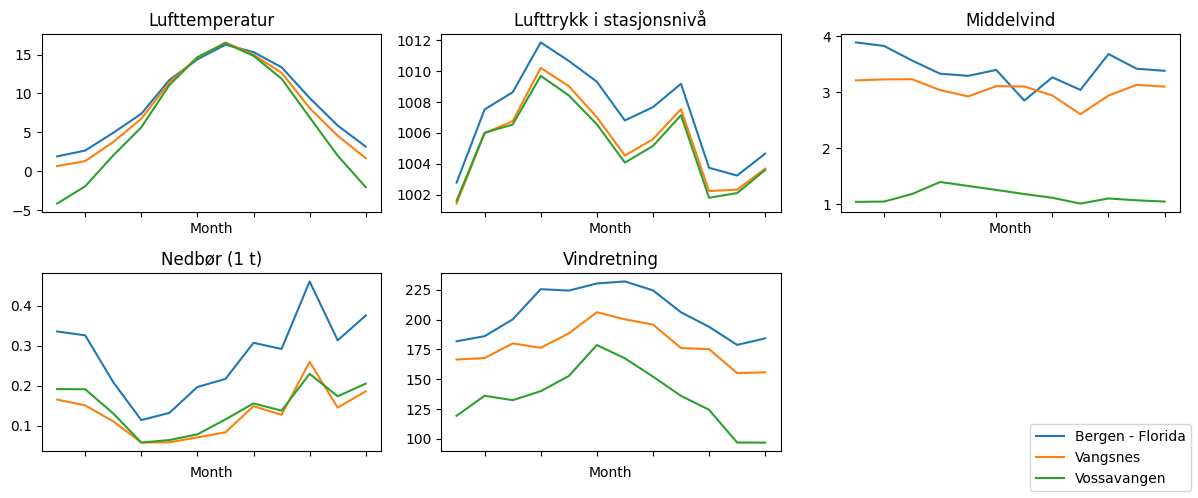

In [39]:
monthly_data = weather_data_by_time.groupby(weather_data_by_time.index.month).mean()
measurements = monthly_data.columns.levels[0]

fig, ax = plt.subplots(
    nrows=len(measurements)//2,
    ncols=3,
    figsize=(4 * (len(measurements)//2+1), 5),
    sharex=True
)
print(len(measurements))

for i, measurement in enumerate(measurements):
    ax[i//3, i%3].plot(monthly_data[measurement])

    ax[i//3, i%3].set_title(measurement)
    ax[i//3, i%3].set_xlabel("Month")
    ax[i//3, i%3].set_xticklabels([])

fig.delaxes(ax[1, 2])
fig.legend(monthly_data.columns.levels[1], loc="lower right")
fig.tight_layout()
plt.show()

In [73]:
flat_weather_data_by_time = weather_data_by_time.copy()
flat_weather_data_by_time.columns = flat_weather_data_by_time.columns.droplevel(1)
flat_weather_data_by_time["year"] = flat_weather_data_by_time.index.year
flat_weather_data_by_time["hour"] = flat_weather_data_by_time.index.hour
flat_weather_data_by_time["weekday"] = flat_weather_data_by_time.index.weekday
flat_weather_data_by_time["month"] = flat_weather_data_by_time.index.month

merged_df = pd.merge(left=flat_weather_data_by_time, right=consumption_by_group, how="inner", left_on="Tid(norsk normaltid)", right_on="startTime").dropna()

In [76]:
x = merged_df[monthly_data.columns.levels[0]]
x = x.T.groupby(x.T.index).mean().T

y = merged_df[consumption_by_group.columns].sum(axis=1)

In [77]:
X = sm.add_constant(x)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     7652.
Date:                Tue, 10 Feb 2026   Prob (F-statistic):               0.00
Time:                        13:27:24   Log-Likelihood:            -5.9085e+05
No. Observations:               42922   AIC:                         1.182e+06
Df Residuals:                   42916   BIC:                         1.182e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [78]:
x = merged_df[list(monthly_data.columns.levels[0])+["year", "weekday", "month", "hour"]]
x = x.T.groupby(x.T.index).mean().T

y = merged_df[consumption_by_group.columns].sum(axis=1)

In [79]:
X = sm.add_constant(x)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                 1.245e+04
Date:                Tue, 10 Feb 2026   Prob (F-statistic):               0.00
Time:                        13:27:28   Log-Likelihood:            -5.7698e+05
No. Observations:               42922   AIC:                         1.154e+06
Df Residuals:                   42912   BIC:                         1.154e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   


### 2. Påvirkning fra vær
Hvilke værfaktorer påvirker forbruket i **NO5** mest?  
Er det andre faktorer som påvirker forbruket, i så fall hvilke?

* Vær faktorer:
    * Lufttemperatur er den klart viktigste værfaktoren.
    * Lufttrykk og vind har mindre, men fortsatt god effekt.
    * Nedbør og vindretning påvirker forbruket svært lite.

* Andre faktorer:
    * År/trend har stor effekt.
    * Tid på døgnet (hour) også god effekt.
    * Sesong (month) og ukedag har grei effekt.